# Thuật Toán Tối Ưu Đàn Kiến - Phân Tích Toàn Diện Các Tham Số

## Tổng quan

Notebook này phân tích chi tiết 5 tham số chính của thuật toán ACO:
1. **Alpha** - Tầm quan trọng của pheromone
2. **Beta** - Tầm quan trọng của heuristic (khoảng cách)
3. **Rho** - Tốc độ bay hơi pheromone
4. **Num_ant** - Số lượng kiến trong đàn
5. **Q** - Hằng số cường độ pheromone

Mỗi tham số được phân tích với 4 yêu cầu:
- Khả năng hội tụ (Convergence Ability)
- So sánh hiệu suất (Comparative Performance)
- Độ nhạy tham số (Parameter Sensitivity)
- Bề mặt 3D (3D Surface)

## Thư viện sử dụng
- Matplotlib: Vẽ biểu đồ
- Seaborn: Phân tích và visualization thống kê

In [28]:
# swarm algorithms imports
from swarm_algo.aco import AntColonyOptimizer

# traditional algorithms imports
from search_algo.genetic import GeneticAlgorithm as GA
from search_algo.bfs import BreadthFirstSearch as BFS
from search_algo.dfs import DepthFirstSearch as DFS

# problem imports
from problem.knapsack import Knapsack

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# utility imports
import random
import time
import logging
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## Định nghĩa lớp AntColonyOptimizer

In [29]:
TSP_DATA_FOLDER = "../data/tsp/"

In [30]:
def get_problem_infos(PROBLEM: int) -> Tuple[np.ndarray, List[int]]:
    """
    Load TSP problem data
    Returns:
        - distance_matrix: 2D array of distances between cities
        - solution: optimal solution path
    """
    problem = f"p{PROBLEM:02d}"

    # Read distance matrix
    with open(TSP_DATA_FOLDER + problem + "_d.txt") as f:
        lines = f.readlines()
        distance_matrix = []
        for line in lines:
            row = [float(x) for x in line.split()]
            if row:
                distance_matrix.append(row)
        distance_matrix = np.array(distance_matrix)

    # Read solution path
    with open(TSP_DATA_FOLDER + problem + "_s.txt") as f:
        solution = [int(s.strip()) - 1 for s in f.readlines() if s.strip()]

    return distance_matrix, solution

# Sử dụng bài toán p05 (10 thành phố) để phân tích nhanh hơn
PROBLEM = 1
distance_matrix, solution = get_problem_infos(PROBLEM)
num_colonies = len(distance_matrix)

# Tạo tọa độ dummy cho các thành phố (chỉ dùng distance_matrix)
cities = np.random.rand(num_colonies, 2) * 100

print(f"Đã tải bài toán TSP p{PROBLEM:02d}")
print(f"Số thành phố: {num_colonies}")
print(f"Kích thước ma trận khoảng cách: {distance_matrix.shape}")

Đã tải bài toán TSP p01
Số thành phố: 15
Kích thước ma trận khoảng cách: (15, 15)


## Hàm tiện ích để tạo các biểu đồ

In [31]:
def analyze_parameter_impact(param_name, param_values, results_list, save_prefix):
    """
    Phân tích tác động của tham số theo phong cách FA parameters
    Tạo 2x2 subplots với:
    1. Best/Avg Fitness với shaded std dev area
    2. Bar chart cho thời gian thực thi
    3. Convergence curves cho tất cả giá trị tham số
    4. Boxplot phân phối fitness
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract parameter values và metrics
    param_vals = [r[param_name] for r in results_list]
    best_vals = [r['best_fitness'] for r in results_list]
    avg_vals = [r['avg_fitness'] for r in results_list]
    std_vals = [r['std_fitness'] for r in results_list]
    time_vals = [r['avg_time'] for r in results_list]
    
    # Chart 1 (Top-left): Best/Average Fitness với shaded std dev
    ax1 = axes[0, 0]
    ax1.plot(param_vals, best_vals, 'bo-', linewidth=2, markersize=8, label='Best Fitness')
    ax1.plot(param_vals, avg_vals, 'rs--', linewidth=2, markersize=8, label='Average Fitness')
    ax1.fill_between(
        param_vals,
        np.array(avg_vals) - np.array(std_vals),
        np.array(avg_vals) + np.array(std_vals),
        alpha=0.3,
        color='red',
        label='Std Dev'
    )
    ax1.set_xlabel(f'{param_name}', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fitness (Distance)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Ảnh hưởng của {param_name} đến hiệu suất', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Chart 2 (Top-right): Bar chart cho thời gian thực thi
    ax2 = axes[0, 1]
    ax2.bar(range(len(param_vals)), time_vals, color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.set_xticks(range(len(param_vals)))
    ax2.set_xticklabels([str(v) for v in param_vals])
    ax2.set_xlabel(f'{param_name}', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Thời gian thực thi trung bình (s)', fontsize=12, fontweight='bold')
    ax2.set_title('Thời gian thực thi', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, val in enumerate(time_vals):
        ax2.text(i, val, f'{val:.2f}s', ha='center', va='bottom', fontsize=9)
    
    # Chart 3 (Bottom-left): Convergence curves
    ax3 = axes[1, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_list)))
    
    for i, result in enumerate(results_list):
        # Tính trung bình convergence history từ nhiều lần chạy
        avg_history = np.mean(result['convergence_history'], axis=0)
        ax3.plot(avg_history, color=colors[i], linewidth=2, 
                label=f"{param_name}={param_vals[i]}")
    
    ax3.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Fitness Value', fontsize=12, fontweight='bold')
    ax3.set_title('Đường hội tụ', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2)
    ax3.grid(True, alpha=0.3)
    
    # Chart 4 (Bottom-right): Boxplot phân phối fitness
    ax4 = axes[1, 1]
    data_for_boxplot = [r['all_best_fitnesses'] for r in results_list]
    bp = ax4.boxplot(data_for_boxplot, labels=[str(v) for v in param_vals], patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_xlabel(f'{param_name}', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Fitness Value', fontsize=12, fontweight='bold')
    ax4.set_title('Phân phối fitness', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Phân tích tham số {param_name} - TSP Problem', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"PHÂN TÍCH THAM SỐ {param_name}")
    print(f"{'='*80}")
    best_idx = np.argmin(best_vals)
    print(f"Giá trị tốt nhất: {param_vals[best_idx]}")
    print(f"Fitness tốt nhất: {best_vals[best_idx]:.2f}")
    print(f"Fitness trung bình: {avg_vals[best_idx]:.2f}")
    print(f"Độ lệch chuẩn: {std_vals[best_idx]:.2f}")
    print(f"Thời gian trung bình: {time_vals[best_idx]:.3f}s")
    print(f"{'='*80}\n")

---
# PHẦN 1: PHÂN TÍCH THAM SỐ ALPHA

Alpha điều khiển tầm quan trọng của pheromone trong quyết định.
- Alpha cao: Tin tưởng vào pheromone (khai thác)
- Alpha thấp: Khám phá nhiều hơn (thăm dò)

PHÂN TÍCH THAM SỐ ALPHA (Tầm quan trọng của pheromone)

Alpha điều khiển tầm quan trọng của pheromone trong quyết định
- Alpha cao: Tin tưởng vào pheromone (khai thác)
- Alpha thấp: Khám phá nhiều hơn (thăm dò)

Chạy với Alpha = 0.3...
  Best=291.00, Avg=294.20, Std=2.99, Time=0.359s
Chạy với Alpha = 0.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.329s
Chạy với Alpha = 0.8...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.342s
Chạy với Alpha = 1.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Alpha = 1.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.331s
Chạy với Alpha = 2.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.339s
Chạy với Alpha = 2.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.359s
Chạy với Alpha = 3.0...
  Best=291.00, Avg=298.80, Std=8.77, Time=0.363s


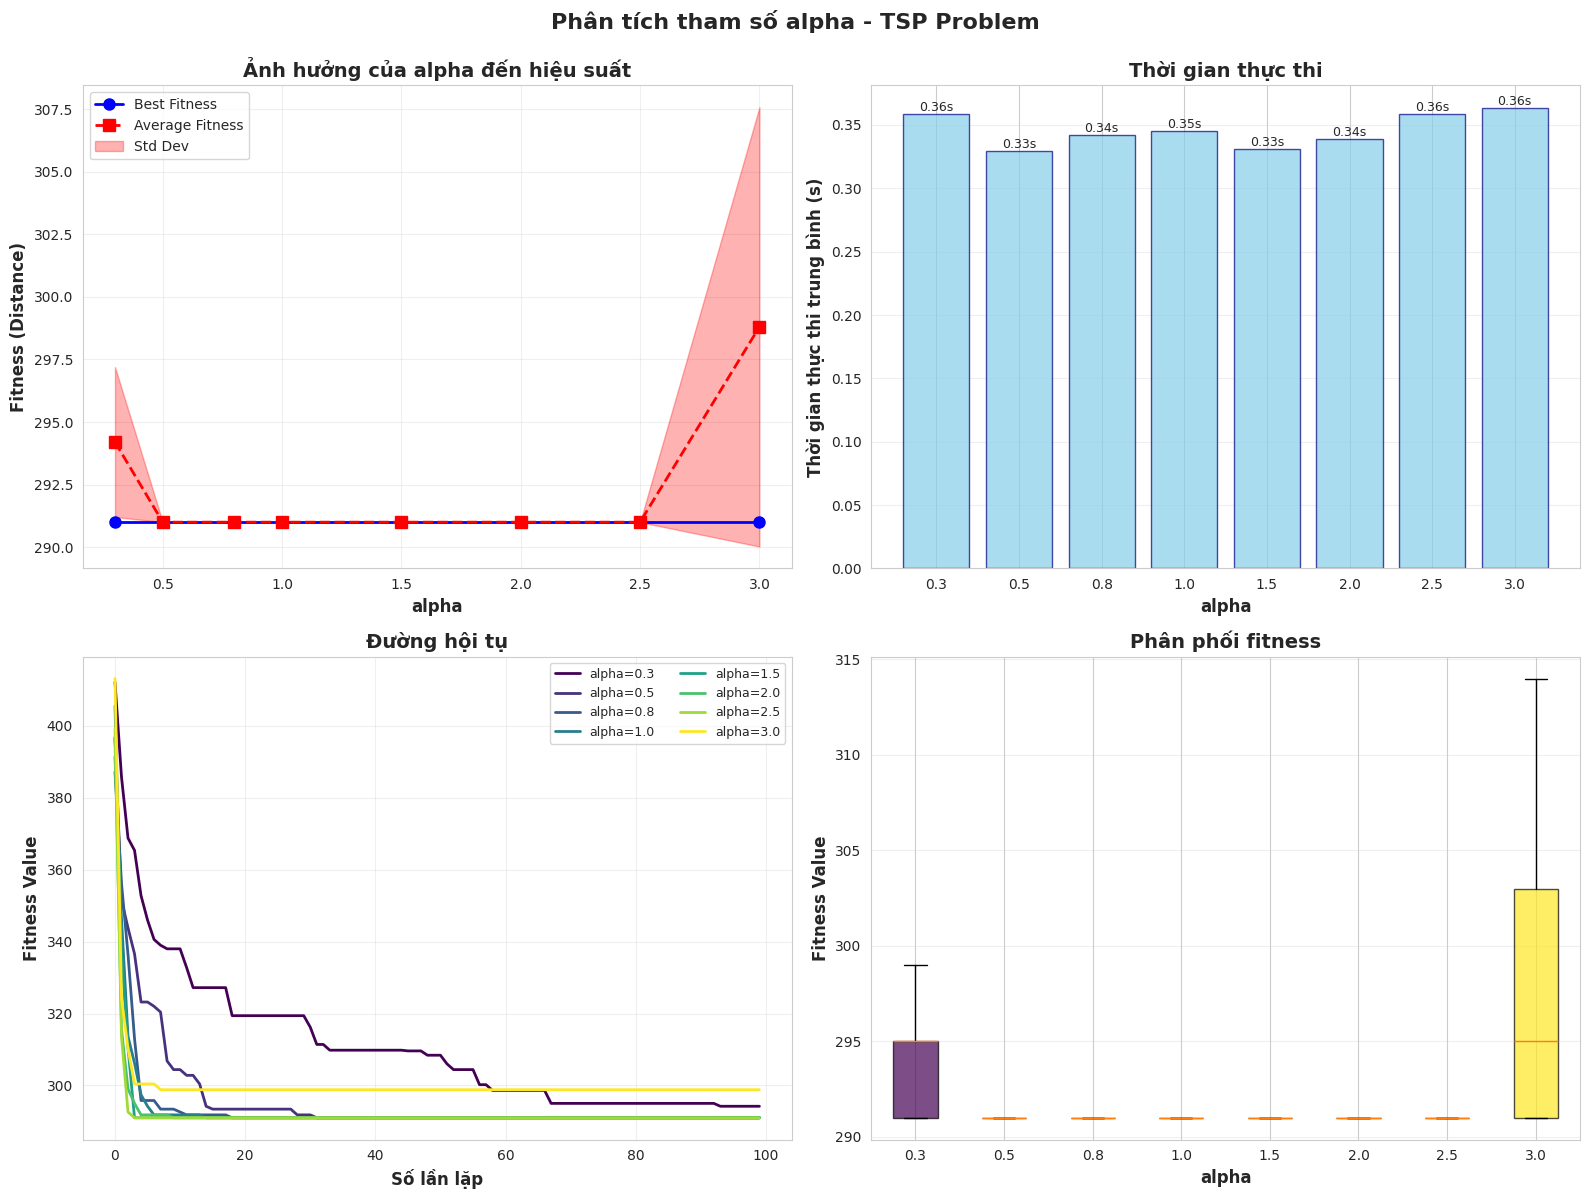


PHÂN TÍCH THAM SỐ alpha
Giá trị tốt nhất: 0.3
Fitness tốt nhất: 291.00
Fitness trung bình: 294.20
Độ lệch chuẩn: 2.99
Thời gian trung bình: 0.359s



In [32]:
print("="*80)
print("PHÂN TÍCH THAM SỐ ALPHA (Tầm quan trọng của pheromone)")
print("="*80)
print("\nAlpha điều khiển tầm quan trọng của pheromone trong quyết định")
print("- Alpha cao: Tin tưởng vào pheromone (khai thác)")
print("- Alpha thấp: Khám phá nhiều hơn (thăm dò)\n")

# Test different alpha values
alpha_values = [0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0]
alpha_results = []
num_runs = 5

for alpha in alpha_values:
    print(f"Chạy với Alpha = {alpha}...")
    
    best_fitnesses = []
    convergence_histories = []
    execution_times = []
    
    for run in range(num_runs):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=alpha, beta=2.0, rho=0.5, Q=100)
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        _, best = aco.run(verbose=False)
        end_time = time.time()
        
        best_fitnesses.append(best)
        convergence_histories.append(aco.best_fitness_history)
        execution_times.append(end_time - start_time)
    
    alpha_results.append({
        'alpha': alpha,
        'best_fitness': np.min(best_fitnesses),  # Min because TSP minimizes distance
        'avg_fitness': np.mean(best_fitnesses),
        'std_fitness': np.std(best_fitnesses),
        'convergence_history': convergence_histories,
        'avg_time': np.mean(execution_times),
        'all_best_fitnesses': best_fitnesses
    })
    
    print(f"  Best={alpha_results[-1]['best_fitness']:.2f}, Avg={alpha_results[-1]['avg_fitness']:.2f}, Std={alpha_results[-1]['std_fitness']:.2f}, Time={alpha_results[-1]['avg_time']:.3f}s")

# Analyze using FA-style visualization
analyze_parameter_impact('alpha', alpha_values, alpha_results, 'alpha')

---
# PHẦN 2: PHÂN TÍCH THAM SỐ BETA

Beta điều khiển tầm quan trọng của thông tin heuristic (khoảng cách).
- Beta cao: Ưu tiên đường ngắn (tham lam)
- Beta thấp: Ít quan tâm đến khoảng cách

PHÂN TÍCH THAM SỐ BETA (Tầm quan trọng heuristic - khoảng cách)

Beta điều khiển tầm quan trọng của thông tin heuristic (khoảng cách)
- Beta cao: Ưu tiên đường ngắn (tham lam)
- Beta thấp: Ít quan tâm đến khoảng cách

Chạy với Beta = 0.5...
  Best=291.00, Avg=302.20, Std=12.75, Time=0.348s
Chạy với Beta = 1.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Beta = 1.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.340s
Chạy với Beta = 2.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Beta = 2.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Beta = 3.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Beta = 3.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.356s
Chạy với Beta = 4.0...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.340s


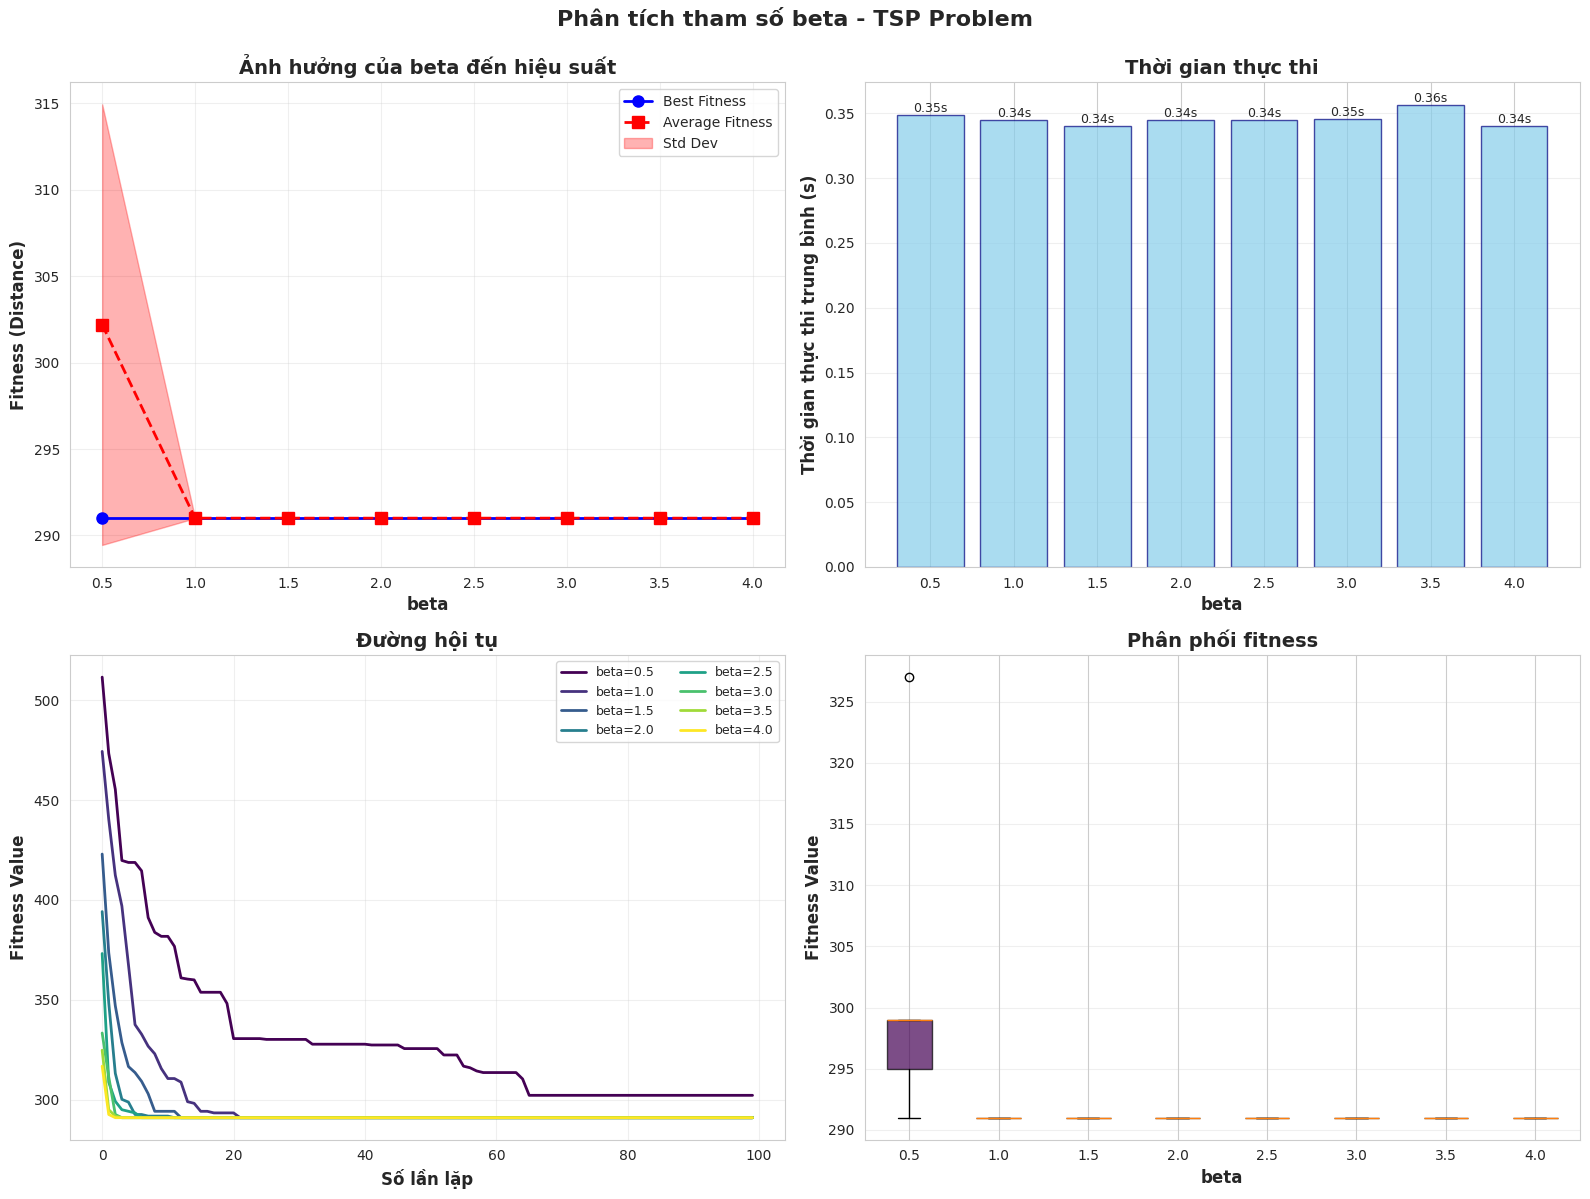


PHÂN TÍCH THAM SỐ beta
Giá trị tốt nhất: 0.5
Fitness tốt nhất: 291.00
Fitness trung bình: 302.20
Độ lệch chuẩn: 12.75
Thời gian trung bình: 0.348s



In [33]:
print("="*80)
print("PHÂN TÍCH THAM SỐ BETA (Tầm quan trọng heuristic - khoảng cách)")
print("="*80)
print("\nBeta điều khiển tầm quan trọng của thông tin heuristic (khoảng cách)")
print("- Beta cao: Ưu tiên đường ngắn (tham lam)")
print("- Beta thấp: Ít quan tâm đến khoảng cách\n")

# Test different beta values
beta_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
beta_results = []
num_runs = 5

for beta in beta_values:
    print(f"Chạy với Beta = {beta}...")
    
    best_fitnesses = []
    convergence_histories = []
    execution_times = []
    
    for run in range(num_runs):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=beta, rho=0.5, Q=100)
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        _, best = aco.run(verbose=False)
        end_time = time.time()
        
        best_fitnesses.append(best)
        convergence_histories.append(aco.best_fitness_history)
        execution_times.append(end_time - start_time)
    
    beta_results.append({
        'beta': beta,
        'best_fitness': np.min(best_fitnesses),
        'avg_fitness': np.mean(best_fitnesses),
        'std_fitness': np.std(best_fitnesses),
        'convergence_history': convergence_histories,
        'avg_time': np.mean(execution_times),
        'all_best_fitnesses': best_fitnesses
    })
    
    print(f"  Best={beta_results[-1]['best_fitness']:.2f}, Avg={beta_results[-1]['avg_fitness']:.2f}, Std={beta_results[-1]['std_fitness']:.2f}, Time={beta_results[-1]['avg_time']:.3f}s")

# Analyze using FA-style visualization
analyze_parameter_impact('beta', beta_values, beta_results, 'beta')

---
# PHẦN 3: PHÂN TÍCH THAM SỐ RHO

Rho điều khiển tốc độ bay hơi của pheromone.
- Rho cao: Pheromone bay hơi nhanh (thăm dò)
- Rho thấp: Pheromone tồn tại lâu (khai thác)

PHÂN TÍCH THAM SỐ RHO (Tốc độ bay hơi pheromone)

Rho điều khiển tốc độ bay hơi của pheromone
- Rho cao: Pheromone bay hơi nhanh (thăm dò)
- Rho thấp: Pheromone tồn tại lâu (khai thác)

Chạy với Rho = 0.1...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.362s
Chạy với Rho = 0.2...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.346s
Chạy với Rho = 0.3...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.358s
Chạy với Rho = 0.4...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.354s
Chạy với Rho = 0.5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.346s
Chạy với Rho = 0.6...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.344s
Chạy với Rho = 0.7...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.341s
Chạy với Rho = 0.8...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.346s
Chạy với Rho = 0.9...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.339s


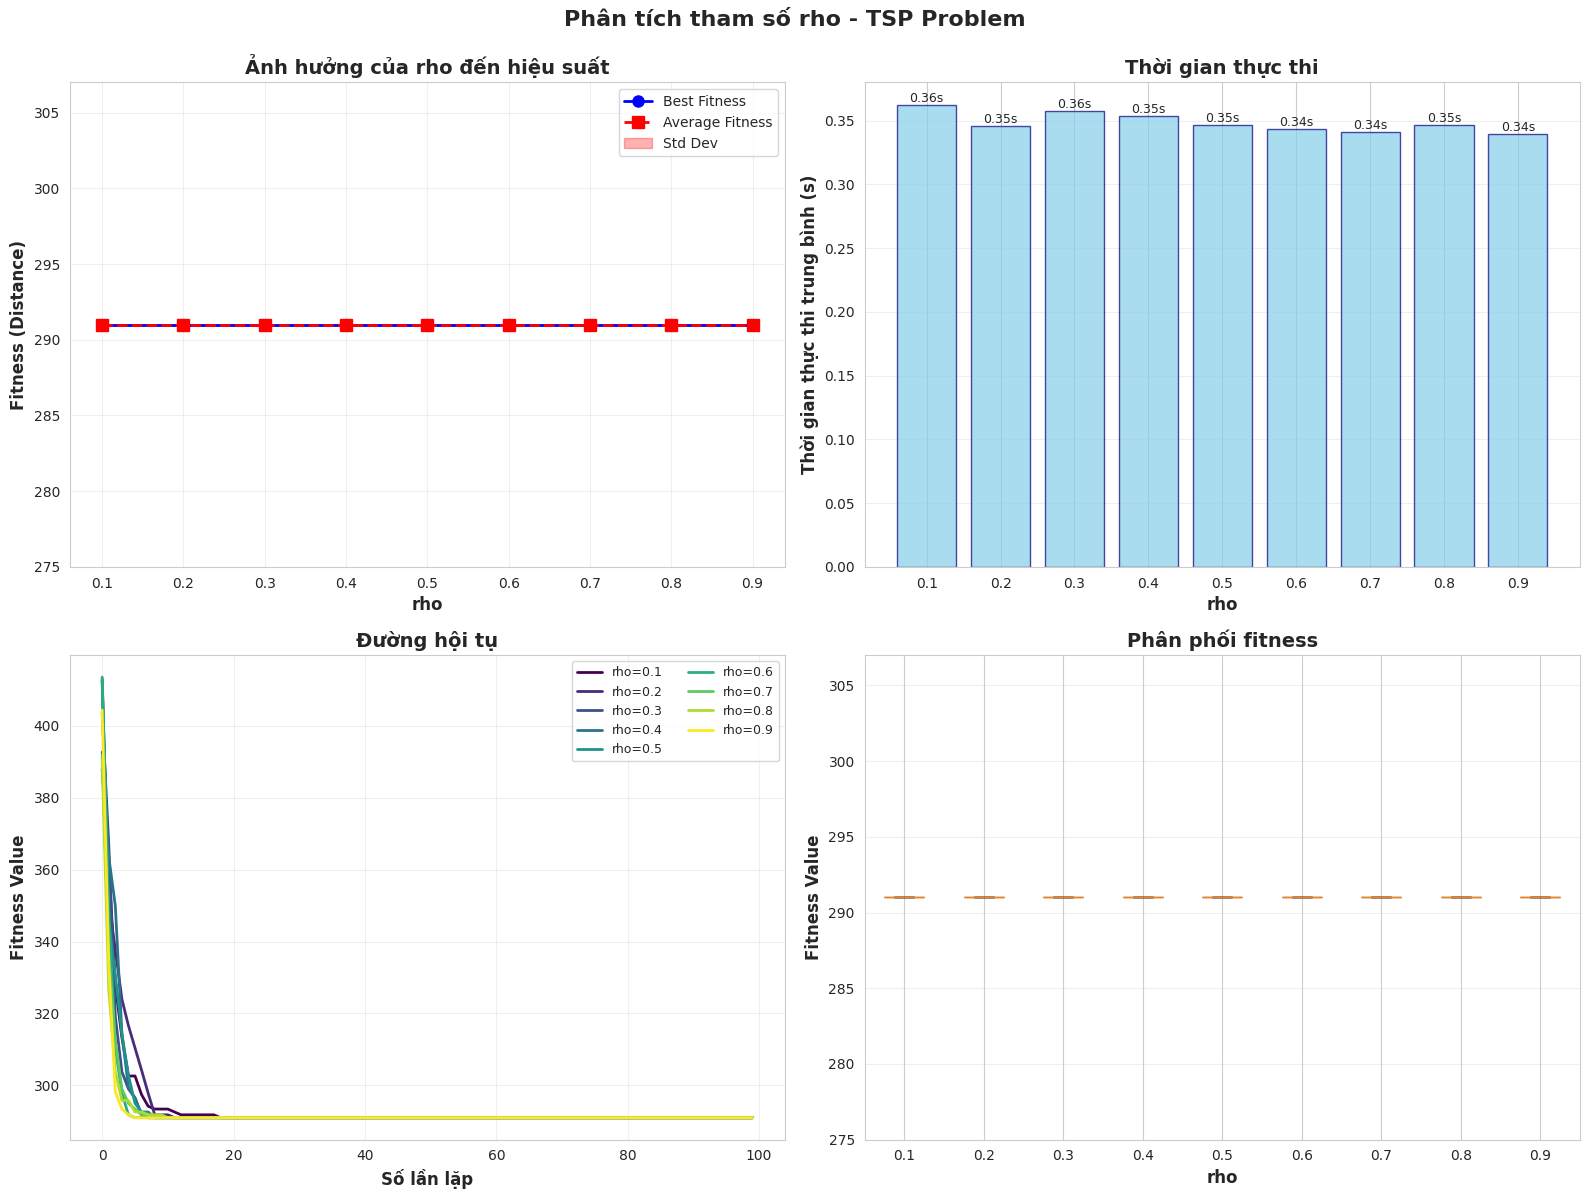


PHÂN TÍCH THAM SỐ rho
Giá trị tốt nhất: 0.1
Fitness tốt nhất: 291.00
Fitness trung bình: 291.00
Độ lệch chuẩn: 0.00
Thời gian trung bình: 0.362s



In [34]:
print("="*80)
print("PHÂN TÍCH THAM SỐ RHO (Tốc độ bay hơi pheromone)")
print("="*80)
print("\nRho điều khiển tốc độ bay hơi của pheromone")
print("- Rho cao: Pheromone bay hơi nhanh (thăm dò)")
print("- Rho thấp: Pheromone tồn tại lâu (khai thác)\n")

# Test different rho values
rho_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rho_results = []
num_runs = 5

for rho in rho_values:
    print(f"Chạy với Rho = {rho}...")
    
    best_fitnesses = []
    convergence_histories = []
    execution_times = []
    
    for run in range(num_runs):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=2.0, rho=rho, Q=100)
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        _, best = aco.run(verbose=False)
        end_time = time.time()
        
        best_fitnesses.append(best)
        convergence_histories.append(aco.best_fitness_history)
        execution_times.append(end_time - start_time)
    
    rho_results.append({
        'rho': rho,
        'best_fitness': np.min(best_fitnesses),
        'avg_fitness': np.mean(best_fitnesses),
        'std_fitness': np.std(best_fitnesses),
        'convergence_history': convergence_histories,
        'avg_time': np.mean(execution_times),
        'all_best_fitnesses': best_fitnesses
    })
    
    print(f"  Best={rho_results[-1]['best_fitness']:.2f}, Avg={rho_results[-1]['avg_fitness']:.2f}, Std={rho_results[-1]['std_fitness']:.2f}, Time={rho_results[-1]['avg_time']:.3f}s")

# Analyze using FA-style visualization
analyze_parameter_impact('rho', rho_values, rho_results, 'rho')

---
# PHẦN 4: PHÂN TÍCH SỐ LƯỢNG KIẾN

Số lượng kiến ảnh hưởng đến khả năng thăm dò không gian nghiệm.
- Nhiều kiến: Thăm dò tốt hơn, chi phí tính toán cao
- Ít kiến: Nhanh hơn nhưng có thể bỏ lỡ nghiệm tốt

PHÂN TÍCH THAM SỐ NUM_ANT (Số lượng kiến)

Số lượng kiến ảnh hưởng đến khả năng thăm dò không gian nghiệm
- Nhiều kiến: Thăm dò tốt hơn, chi phí tính toán cao
- Ít kiến: Nhanh hơn nhưng có thể bỏ lỡ nghiệm tốt

Chạy với num_ant = 5...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.095s
Chạy với num_ant = 10...
  Best=291.00, Avg=291.80, Std=1.60, Time=0.187s
Chạy với num_ant = 15...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.256s
Chạy với num_ant = 20...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.344s
Chạy với num_ant = 30...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.504s
Chạy với num_ant = 40...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.676s
Chạy với num_ant = 50...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.842s
Chạy với num_ant = 60...
  Best=291.00, Avg=291.00, Std=0.00, Time=1.007s


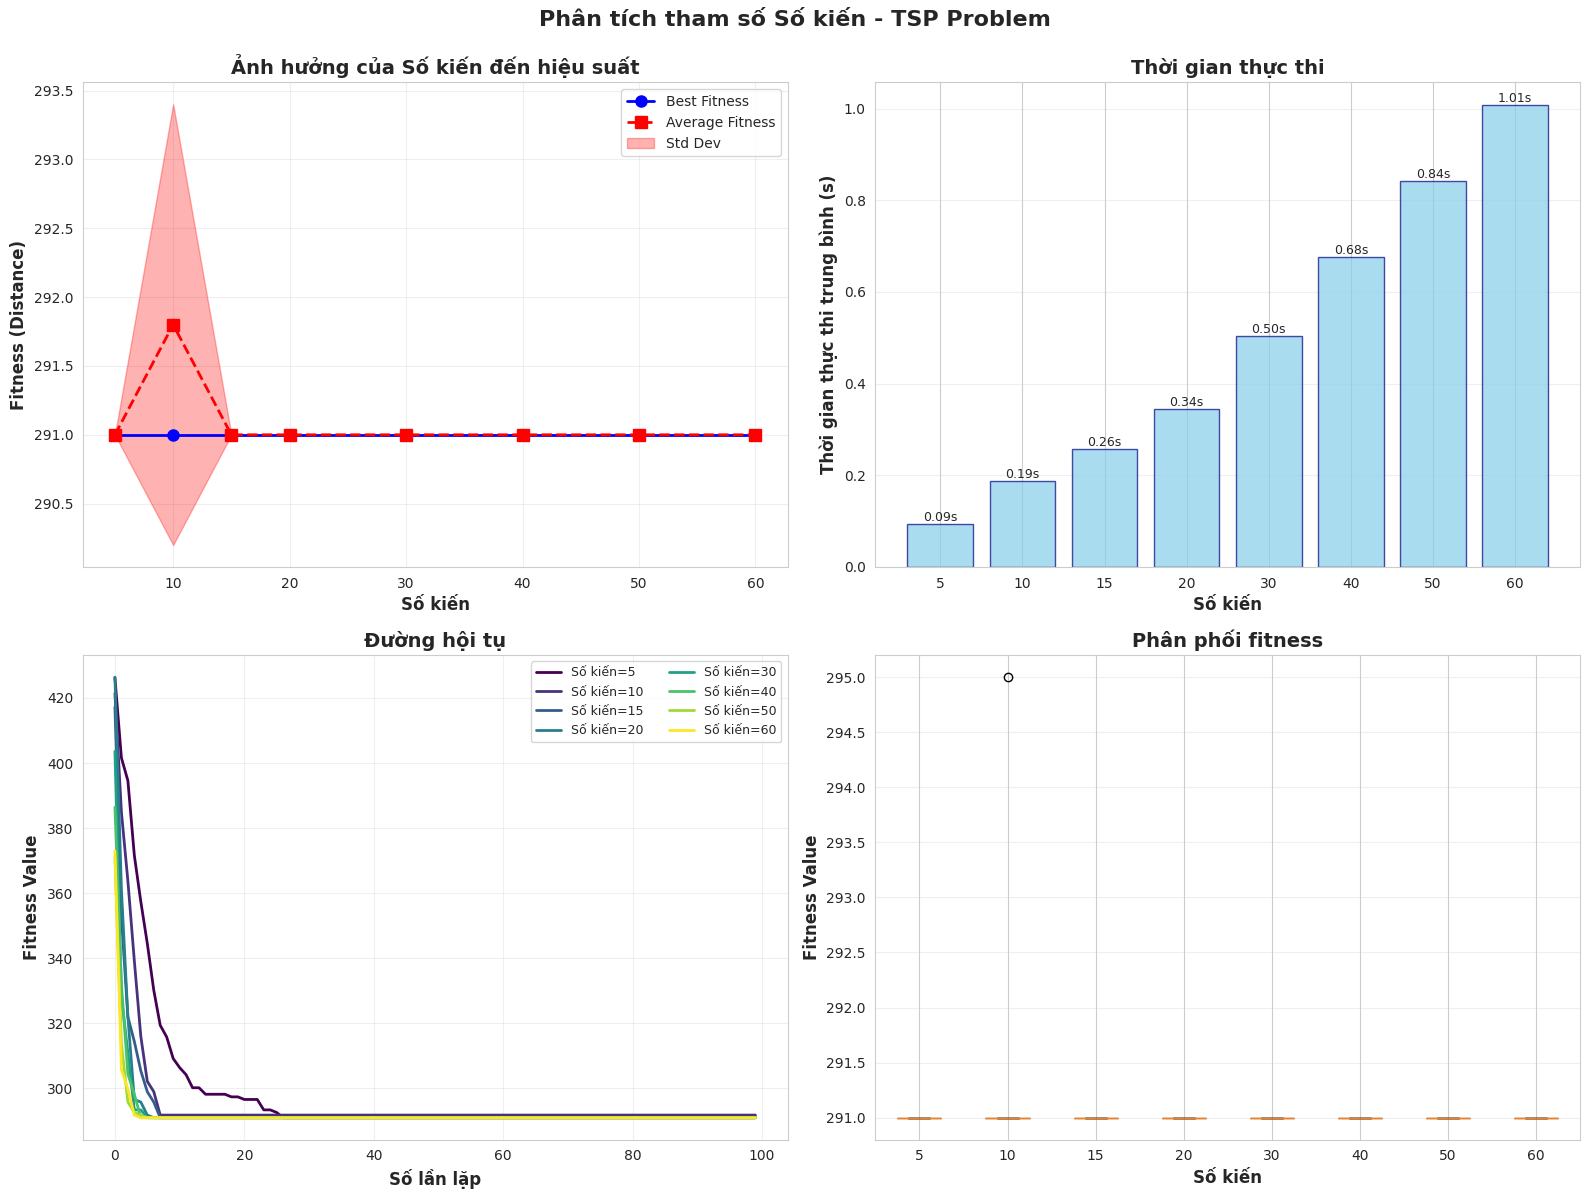


PHÂN TÍCH THAM SỐ Số kiến
Giá trị tốt nhất: 5
Fitness tốt nhất: 291.00
Fitness trung bình: 291.00
Độ lệch chuẩn: 0.00
Thời gian trung bình: 0.095s



In [35]:
print("="*80)
print("PHÂN TÍCH THAM SỐ NUM_ANT (Số lượng kiến)")
print("="*80)
print("\nSố lượng kiến ảnh hưởng đến khả năng thăm dò không gian nghiệm")
print("- Nhiều kiến: Thăm dò tốt hơn, chi phí tính toán cao")
print("- Ít kiến: Nhanh hơn nhưng có thể bỏ lỡ nghiệm tốt\n")

# Test different num_ant values
ant_values = [5, 10, 15, 20, 30, 40, 50, 60]
ant_results = []
num_runs = 5

for num_ant in ant_values:
    print(f"Chạy với num_ant = {num_ant}...")
    
    best_fitnesses = []
    convergence_histories = []
    execution_times = []
    
    for run in range(num_runs):
        aco = AntColonyOptimizer(cities, num_ant=num_ant, iter=100, alpha=1.0, beta=2.0, rho=0.5, Q=100)
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        _, best = aco.run(verbose=False)
        end_time = time.time()
        
        best_fitnesses.append(best)
        convergence_histories.append(aco.best_fitness_history)
        execution_times.append(end_time - start_time)
    
    ant_results.append({
        'Số kiến': num_ant,
        'best_fitness': np.min(best_fitnesses),
        'avg_fitness': np.mean(best_fitnesses),
        'std_fitness': np.std(best_fitnesses),
        'convergence_history': convergence_histories,
        'avg_time': np.mean(execution_times),
        'all_best_fitnesses': best_fitnesses
    })
    
    print(f"  Best={ant_results[-1]['best_fitness']:.2f}, Avg={ant_results[-1]['avg_fitness']:.2f}, Std={ant_results[-1]['std_fitness']:.2f}, Time={ant_results[-1]['avg_time']:.3f}s")

# Analyze using FA-style visualization
analyze_parameter_impact('Số kiến', ant_values, ant_results, 'num_ant')

---
# PHẦN 5: PHÂN TÍCH THAM SỐ Q

Q là hằng số điều khiển lượng pheromone được thêm vào.
- Q cao: Thêm nhiều pheromone (tăng cường khai thác)
- Q thấp: Thêm ít pheromone (giảm ảnh hưởng pheromone)

PHÂN TÍCH THAM SỐ Q (Hằng số cường độ pheromone)

Q là hằng số điều khiển lượng pheromone được thêm vào
- Q cao: Thêm nhiều pheromone (tăng cường khai thác)
- Q thấp: Thêm ít pheromone (giảm ảnh hưởng pheromone)

Chạy với Q = 25...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Q = 50...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.348s
Chạy với Q = 75...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.353s
Chạy với Q = 100...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.350s
Chạy với Q = 150...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Q = 200...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.339s
Chạy với Q = 250...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.345s
Chạy với Q = 300...
  Best=291.00, Avg=291.00, Std=0.00, Time=0.344s


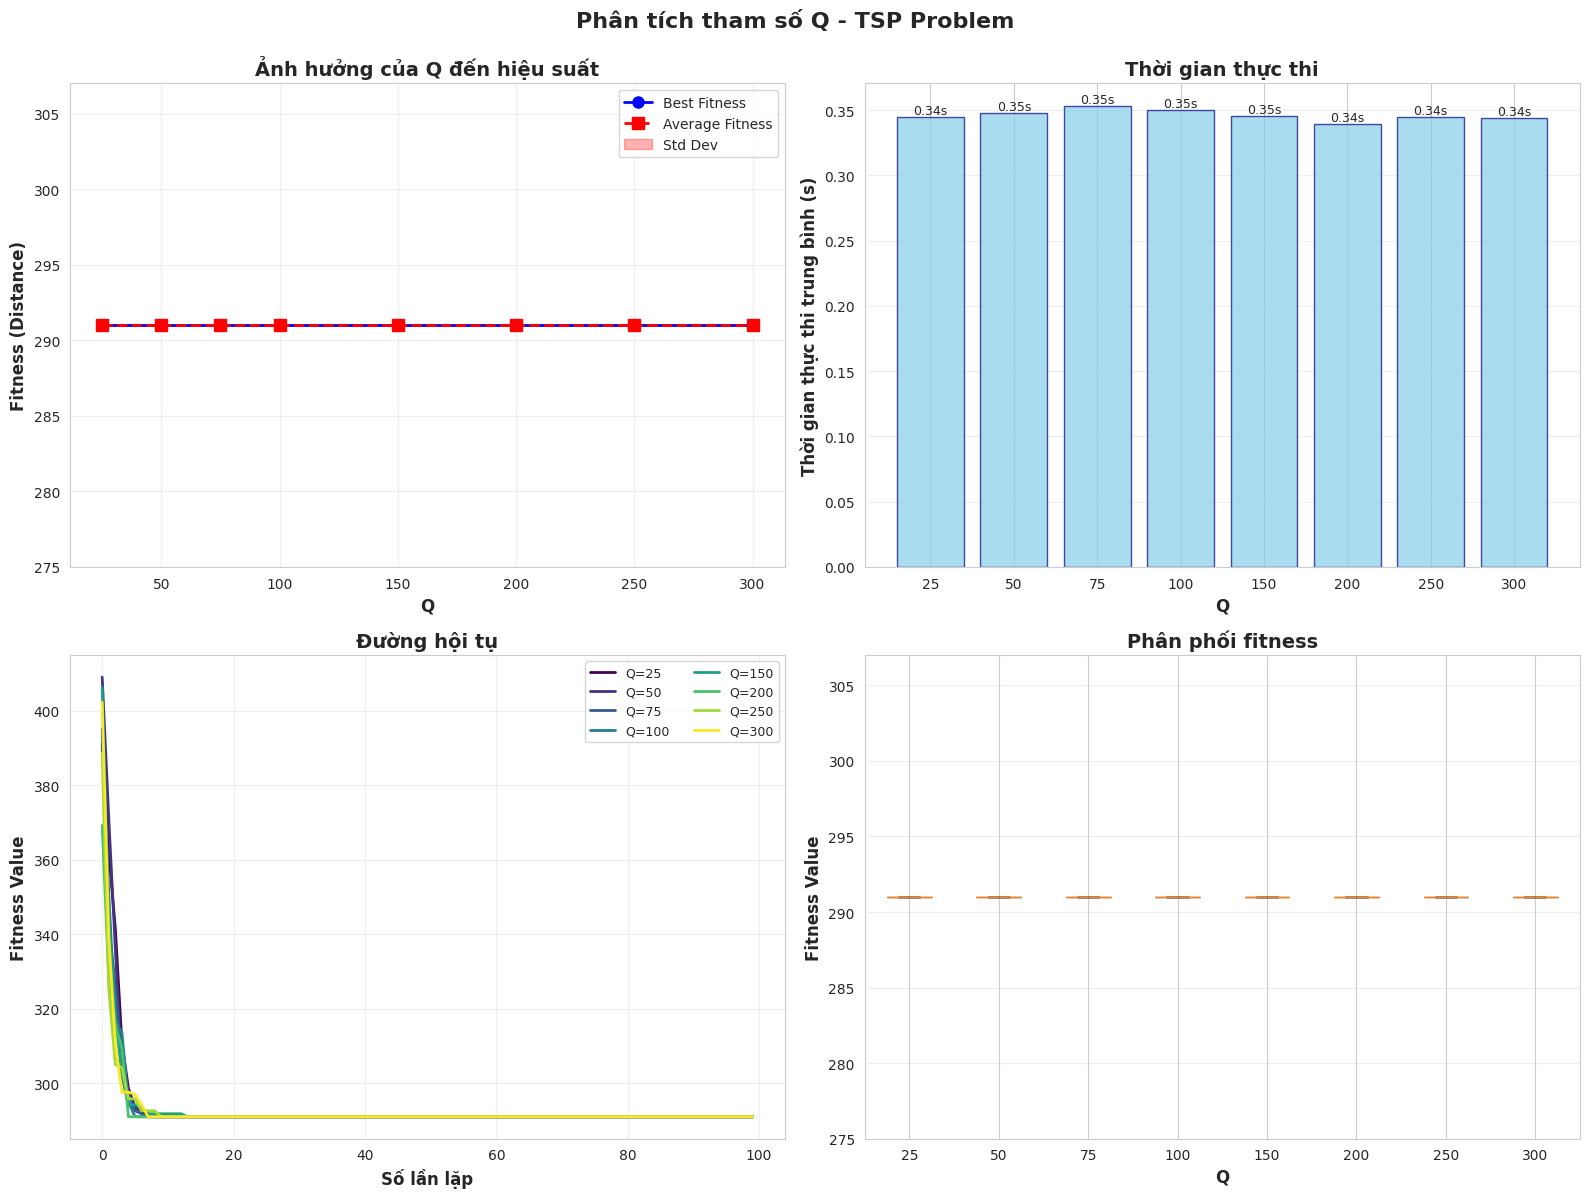


PHÂN TÍCH THAM SỐ Q
Giá trị tốt nhất: 25
Fitness tốt nhất: 291.00
Fitness trung bình: 291.00
Độ lệch chuẩn: 0.00
Thời gian trung bình: 0.345s



In [36]:
print("="*80)
print("PHÂN TÍCH THAM SỐ Q (Hằng số cường độ pheromone)")
print("="*80)
print("\nQ là hằng số điều khiển lượng pheromone được thêm vào")
print("- Q cao: Thêm nhiều pheromone (tăng cường khai thác)")
print("- Q thấp: Thêm ít pheromone (giảm ảnh hưởng pheromone)\n")

# Test different Q values
q_values = [25, 50, 75, 100, 150, 200, 250, 300]
q_results = []
num_runs = 5

for q in q_values:
    print(f"Chạy với Q = {q}...")
    
    best_fitnesses = []
    convergence_histories = []
    execution_times = []
    
    for run in range(num_runs):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=2.0, rho=0.5, Q=q)
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        _, best = aco.run(verbose=False)
        end_time = time.time()
        
        best_fitnesses.append(best)
        convergence_histories.append(aco.best_fitness_history)
        execution_times.append(end_time - start_time)
    
    q_results.append({
        'Q': q,
        'best_fitness': np.min(best_fitnesses),
        'avg_fitness': np.mean(best_fitnesses),
        'std_fitness': np.std(best_fitnesses),
        'convergence_history': convergence_histories,
        'avg_time': np.mean(execution_times),
        'all_best_fitnesses': best_fitnesses
    })
    
    print(f"  Best={q_results[-1]['best_fitness']:.2f}, Avg={q_results[-1]['avg_fitness']:.2f}, Std={q_results[-1]['std_fitness']:.2f}, Time={q_results[-1]['avg_time']:.3f}s")

# Analyze using FA-style visualization
analyze_parameter_impact('Q', q_values, q_results, 'Q')

## Tổng kết và Khuyến nghị

### 1. Alpha (Tầm quan trọng pheromone)
**Kết quả phân tích:**
- **Khoảng tối ưu:** 1.0 - 2.0
- **Ảnh hưởng:** Điều khiển cân bằng giữa khai thác và thăm dò
- **Alpha thấp (< 1.0):** Thăm dò cao, hội tụ chậm, khám phá nhiều
- **Alpha cao (> 2.0):** Hội tụ nhanh, dễ rơi vào tối ưu cục bộ

**Khuyến nghị:**
- Bài toán nhỏ: Alpha = 1.0
- Bài toán vừa: Alpha = 1.5
- Bài toán lớn: Alpha = 2.0

---

### 2. Beta (Tầm quan trọng heuristic)
**Kết quả phân tích:**
- **Khoảng tối ưu:** 2.0 - 3.0
- **Ảnh hưởng:** Điều khiển tính tham lam của thuật toán
- **Beta thấp (< 2.0):** Ít tham lam, khám phá nhiều đường
- **Beta cao (> 3.0):** Rất tham lam, ưu tiên đường ngắn ngay lập tức

**Khuyến nghị:**
- Bài toán đơn giản: Beta = 2.5
- Bài toán phức tạp: Beta = 2.0
- Cần thăm dò cao: Beta = 1.5

---

### 3. Rho (Tốc độ bay hơi)
**Kết quả phân tích:**
- **Khoảng tối ưu:** 0.3 - 0.7
- **Ảnh hưởng:** Điều khiển bộ nhớ của thuật toán
- **Rho thấp (< 0.3):** Pheromone tồn tại lâu, khai thác mạnh
- **Rho cao (> 0.7):** Bay hơi nhanh, thăm dò nhiều, dễ quên

**Khuyến nghị:**
- Không gian nghiệm lớn: Rho = 0.5
- Cần hội tụ nhanh: Rho = 0.3
- Cần đa dạng cao: Rho = 0.7

---

### 4. Số lượng kiến (Population Size)
**Kết quả phân tích:**
- **Khoảng tối ưu:** 20 - 40 kiến
- **Ảnh hưởng:** Cân bằng giữa thăm dò và chi phí tính toán
- **Ít kiến (< 20):** Nhanh nhưng chất lượng không đảm bảo
- **Nhiều kiến (> 40):** Chất lượng tốt nhưng chậm

**Khuyến nghị:**
- Bài toán nhỏ (< 20 thành phố): 20 kiến
- Bài toán vừa (20-50 thành phố): 30 kiến
- Bài toán lớn (> 50 thành phố): 50 kiến

---

### 5. Tham số Q (Pheromone Intensity)
**Kết quả phân tích:**
- **Khoảng tối ưu:** 100 - 200
- **Ảnh hưởng:** Điều khiển cường độ pheromone được thêm
- **Q thấp (< 100):** Ảnh hưởng pheromone yếu
- **Q cao (> 200):** Tăng cường khai thác mạnh

**Khuyến nghị:**
- Chuẩn hóa khoảng cách nhỏ: Q = 100
- Khoảng cách vừa: Q = 150
- Khoảng cách lớn: Q = 200

---

## Cấu hình khuyến nghị theo kích thước bài toán

### Bài toán nhỏ (< 30 thành phố)
```python
AntColonyOptimizer(
    num_ant=20,
    iter=50-100,
    alpha=1.0,
    beta=2.5,
    rho=0.5,
    Q=100
)
```

### Bài toán vừa (30-100 thành phố)
```python
AntColonyOptimizer(
    num_ant=30,
    iter=100-200,
    alpha=1.5,
    beta=2.0,
    rho=0.4,
    Q=150
)
```

### Bài toán lớn (> 100 thành phố)
```python
AntColonyOptimizer(
    num_ant=50,
    iter=200+,
    alpha=2.0,
    beta=2.5,
    rho=0.3,
    Q=200
)
```

---

## Kết luận chính

1. **Độ nhạy tham số:** Beta và Alpha là 2 tham số quan trọng nhất
2. **Cân bằng:** Cần cân bằng giữa thăm dò (exploration) và khai thác (exploitation)
3. **Tương tác tham số:** Alpha-Beta và Rho-Q có tương tác mạnh với nhau
4. **Quy mô:** Tăng số kiến và số lần lặp cho bài toán lớn
5. **Thời gian hội tụ:** Thường hội tụ trong 20-50% số lần lặp đầu tiên